In [ ]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "" # just use CPU, pre-trained model

In [ ]:
import matplotlib.pyplot as plt 
from bliss.encoders.autoencoder import OneCenteredGalaxyAE
import torch
import numpy as np

import pytorch_lightning as L

from bliss.datasets.table_utils import column_to_tensor
from bliss.datasets.lsst import prepare_final_galaxy_catalog, prepare_final_star_catalog, get_default_lsst_psf
from astropy.table import Table

from bliss.catalog import FullCatalog

from bliss.datasets.generate_blends import generate_dataset


# Test on dataset from prior

In [ ]:

from bliss.encoders.deblend import GalaxyEncoder


model = GalaxyEncoder("../../models/autoencoder_42_42.pt").to("cpu")
model.load_state_dict(
    torch.load(f"../../models/deblender_42_42.pt", map_location="cpu", weights_only=True)
)

<All keys matched successfully>

In [ ]:
CATSIM_CAT = prepare_final_galaxy_catalog()
STAR_MAGS = prepare_final_star_catalog()
PSF = get_default_lsst_psf()

In [ ]:
# get some blends
L.seed_everything(42)


# galaxy_density = 200
ds = generate_dataset(300, CATSIM_CAT, STAR_MAGS, PSF, 10, slen=40)

Seed set to 42
100%|██████████| 300/300 [00:19<00:00, 15.72it/s]


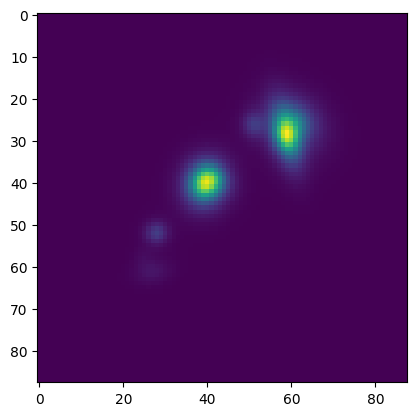

In [ ]:
idx = 20
plt.imshow(ds['noiseless'][idx,  0]  - ds['paddings'][idx, 0])

## Check correctness of images

In [ ]:
slen = 40
tile_slen = 4
exclude = {'images', 'background', 'paddings', 'centered_sources', 'uncentered_sources', 'noiseless'}
full_catalog = FullCatalog(slen, slen, {p:q for p, q in ds.items() if p not in exclude})
tile_catalog = full_catalog.to_tile_params(tile_slen, ignore_extra_sources=True)
tile_catalog.n_sources.shape

NameError: name 'ds' is not defined

In [ ]:
# now let's check deblender performance
model = model.eval()

images =ds['images'].float()
background = ds['background'].float()

with torch.no_grad():
    gparams = model.variational_mode(images, background, tile_catalog)
gparams.shape

torch.Size([300, 10, 10, 8])

In [ ]:
from bliss.render_tiles import render_galaxy_ptiles
from bliss.render_tiles import reconstruct_image_from_ptiles


ptiles = render_galaxy_ptiles(model._dec, tile_catalog.locs, gparams, tile_catalog['galaxy_bools'], 52, 4, )

recon = reconstruct_image_from_ptiles(ptiles, 4)
ptiles.shape, recon.shape

(torch.Size([300, 10, 10, 1, 52, 52]), torch.Size([300, 1, 88, 88]))

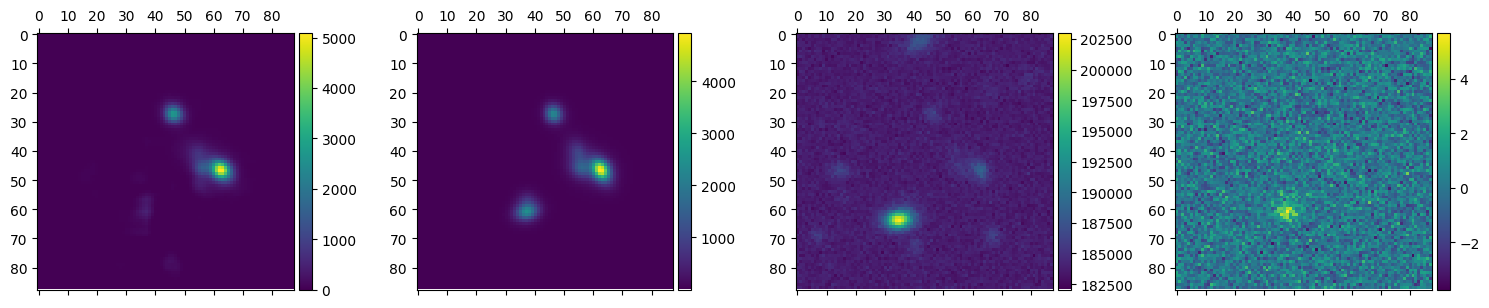

In [ ]:
from bliss.plotting import plot_image

idx = np.random.choice(np.arange(300))

fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=1, ncols=4, figsize=(15, 7))

plot_image(fig, ax1, recon[idx, 0], cmap='viridis')
# plt.colorbar()
# plt.show()
plot_image(fig, ax2, ds['noiseless'][idx, 0] - ds['paddings'][idx, 0], cmap='viridis')
x = recon[idx, 0] + ds['background'][idx, 0] + ds['paddings'][idx, 0]
y = images[idx, 0] 
plot_image(fig, ax3, ds['images'][idx, 0], cmap='viridis')

plot_image(fig, ax4, (y - x) / x.sqrt(), cmap='viridis')

plt.tight_layout()

# Test on toy experiment galaxies (conditioned on true locations)

In [ ]:
seps = torch.arange(0, 18, 0.1)
batch_size = len(seps)
seps.shape, batch_size

(torch.Size([180]), 180)

In [ ]:
from bliss.datasets.lsst import convert_flux_to_mag, get_default_lsst_background
# first centered galaxy, then moving one.
colnames = (
    "fluxnorm_bulge",
    "fluxnorm_disk",
    "fluxnorm_agn",
    "a_b",
    "a_d",
    "b_b",
    "b_d",
    "pa_bulge",
    "pa_disk"
    "i_ab",
    "flux",
)
assert len(colnames) == 10
n_sources = 2
flux1, flux2 = 8e5, 4e5
mag1, mag2 = convert_flux_to_mag(torch.tensor([flux1, flux2]))
mag1, mag2 = mag1.item(), mag2.item()
gparam1 = [0, 1.0, 0, 0, 1.5, 0, 0.7, 45, 45, mag1, flux1]
gparam2 = [0, 1.0, 0, 0, 1.0, 0, 0.7, 135, 135, mag2, flux2]
gparams = torch.tensor([gparam1, gparam2])
gparams = gparams.reshape(1, 2, 11).expand(batch_size, 2, 11)
print(f"INFO: Fluxes correspond to magnitudes ({mag1},{mag2})")

gparams.shape

INFO: Fluxes correspond to magnitudes (22.37712287902832,23.129697799682617)


torch.Size([180, 2, 11])

In [ ]:
slen = 44

# need plocs for later
x0, y0 = 22, 22  # center plocs
plocs = torch.tensor([[[x0, y0], [x0, y0 + sep]] for sep in seps]).reshape(batch_size, 2, 2)

psf = get_default_lsst_psf()
bg = get_default_lsst_background()


In [ ]:
from bliss.datasets.generate_blends import render_full_catalog
from bliss.datasets.background import add_noise_and_background
from bliss.catalog import stack_full_catalogs
bp = 24
size = slen + 2 * bp

# create full catalogs (need separately since `render_blend`` only accepts 1 batch)
images = torch.zeros(batch_size, 1, size, size)
noiseless = torch.zeros(batch_size, 1, size, size)
background = torch.full((batch_size, 1, size, size), bg)
full_cats = [] 

# always add same noise
# assume background dominated
noise = torch.randn_like(images[0]).reshape(1, 1, size, size) * np.sqrt(bg)

for ii in range(batch_size):
    plocs_ii = plocs[ii].reshape(1, 2, 2)
    d = {
        "n_sources": torch.full((1,), n_sources),
        "plocs": plocs_ii,
        "galaxy_bools": torch.ones(1, n_sources, 1),
        "galaxy_params": gparams[ii, None],
        'fluxes': gparams[ii, None, :, -1, None],
        "star_bools": torch.zeros(1, n_sources, 1),
        "star_fluxes": torch.zeros(1, n_sources, 1),
        "star_log_fluxes": torch.zeros(1, n_sources, 1),
    }
    full_cat = FullCatalog(slen, slen, d)
    full_cats.append(full_cat)
    image, _, _ = render_full_catalog(full_cat, psf, slen, bp)

    noiseless[ii] = image
    images[ii] = image + noise + background[ii]

full_cat_all = stack_full_catalogs(full_cats)

In [ ]:
full_cat_all.n_sources.shape, full_cat_all['fluxes'].shape, full_cat_all.max_n_sources

(torch.Size([180]), torch.Size([180, 2, 1]), 2)

In [ ]:
tile_slen = 4
# full_catalog = FullCatalog(slen, slen, {p:q for p, q in ds.items() if p not in exclude})
tile_catalog = full_cat_all.to_tile_params(tile_slen, ignore_extra_sources=True)
tile_catalog.n_sources.shape

torch.Size([180, 11, 11])

In [ ]:
# now let's check deblender performance
model = model.eval()

with torch.no_grad():
    gparams = model.variational_mode(images, background, tile_catalog)
gparams.shape

torch.Size([180, 11, 11, 8])

In [ ]:
from bliss.render_tiles import render_galaxy_ptiles
from bliss.render_tiles import reconstruct_image_from_ptiles


ptiles = render_galaxy_ptiles(model._dec, tile_catalog.locs, gparams, tile_catalog['galaxy_bools'], 52, 4, )

recon = reconstruct_image_from_ptiles(ptiles, 4)
ptiles.shape, recon.shape

(torch.Size([180, 11, 11, 1, 52, 52]), torch.Size([180, 1, 92, 92]))

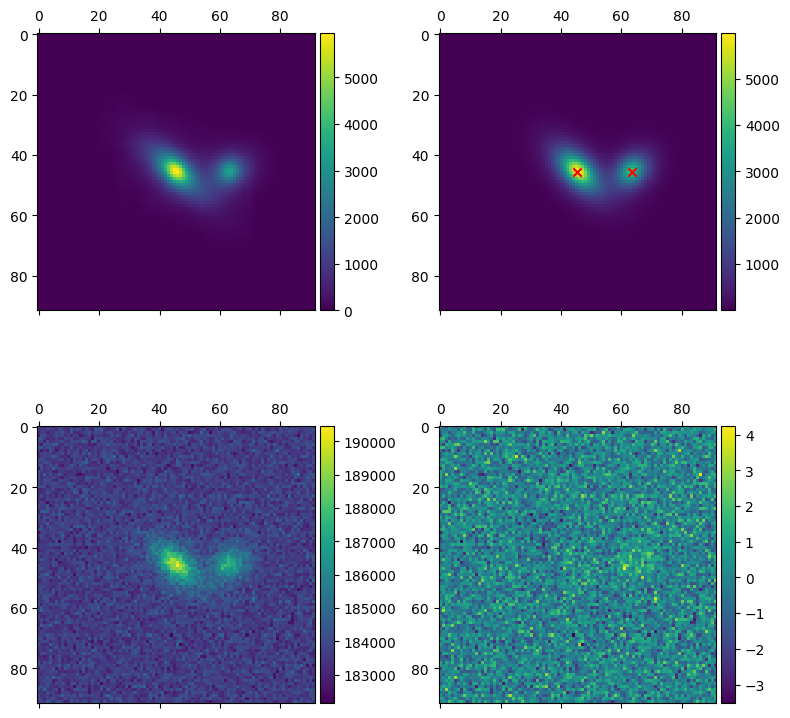

In [ ]:
from bliss.plotting import plot_image

# idx = np.random.choice(np.arange(180))
idx = 179

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 8))

ax1, ax2, ax3, ax4 = axes.ravel()

plot_image(fig, ax1, recon[idx, 0], cmap='viridis')
plot_image(fig, ax2, noiseless[idx, 0], cmap='viridis')
# plt.colorbar()
# plt.show()
plot_image(fig, ax3, images[idx, 0], cmap='viridis')

y, x = full_cat_all.plocs[idx]
ax2.scatter(x - 0.5 + bp, y - 0.5 + bp, marker='x', color='r')

x = recon[idx, 0] + background[idx, 0]
y = images[idx, 0] 
plot_image(fig, ax4, (y - x) / x.sqrt(), cmap='viridis')


# print(idx)
plt.tight_layout()